In [59]:
from motor_control.AROMotorControl import AROMotorControl
mc = AROMotorControl()
mc.readPosition(motorid=1)

197.3299999999872

In [47]:
from template import run_until
dt = 0.005
# Calculate how many iterations the motor should run 
# based on a 2-second duration and the time step.
N = int(2. / dt) 
try:
    run_until(mc.applyTorqueToMotor, N=N, dt=0.005, motorid=1, torque=0.02)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0) # stop the motor
    mc.applyTorqueToMotor(2, 0)
    # applyTorqueToMotor takes the arguments:
    # motorid: the motor to apply the torque to
    # torque: the torque to apply to the motor
    print("motors stopped!")

motors stopped!


motors stopped!


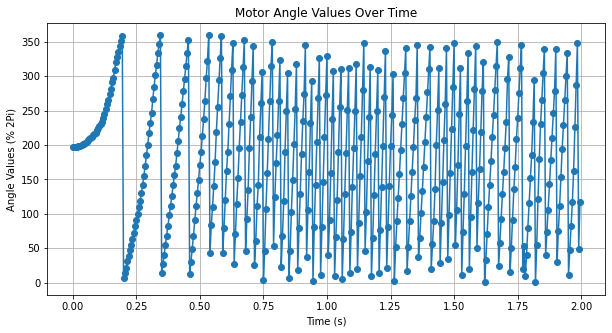

In [60]:
import matplotlib.pyplot as plt
anglevalues =[]
def store_values_and_apply_torques(motorid, torque):
    global anglevalues
    mc.applyTorqueToMotor(motorid=motorid, torque=torque)
    anglevalues.append(mc.readPosition(motorid=motorid))

try:
    run_until(store_values_and_apply_torques, N=N, dt=0.005, motorid=1, torque=0.02)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    print("motors stopped!")


time_values = [i * dt for i in range(len(anglevalues))]

# Plotting the angle values
plt.figure(figsize=(10, 5))
plt.plot(time_values, anglevalues, marker='o', linestyle='-')
plt.title('Motor Angle Values Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle Values (% 2Pi)')
plt.grid()
plt.show()

In [53]:
def clip(output):
    """This function clips the output to a range of -0.1 to -0.02 and 0.02 to 0.1
    this is to ensure that, if there is a lot of friction, a minimal signal is sent
    when the error is not 0 but small, as the motors tend not ro move at all
    before 0.02 nM of torque is applied.
    """
    outabs = abs(output)
    if outabs < 1e-4:
        return 0
    clipped = max(min(outabs, 0.1), 0.02)
    return clipped if output > 0 else -clipped

class PController:
    def __init__(self, Kp):
        self.Kp = Kp
    def shortest_path_error(self, target, current):
        # difference between target and current
        # you sum 180 to the difference and then take the modulo 360 to get the shortest path
        # then you subtract 180 to get the difference between the target and current
        diff = ( target - current + 180 ) % 360 - 180 
        # e.g. target = 360, current = 0, diff = (360 - 0 + 180) % 360 - 180 = 0
        # e.g. target = 180, current = 90, diff = (180 - 90 + 180) % 360 - 180 = -90 -180 = 90
        # e.g. target = 90, current = 180, diff = (90 - 180 + 180) % 360 - 180 = 90 - 180 = -90
        # e.g. target = 0, current = 360, diff = (0 - 360 + 180) % 360 - 180 = -180 - 180 = -360
            # in this case, the next line will sum 360 to the diff and return 0.
        
        if diff < -180:
            diff = diff + 360
        if (current + diff) % 360 == target:
            # if the target is reached, return 0 (the difference)
            return diff
        else:
            # if the target is not reached, return the negative difference
            return -diff
        
    def compute(self, target, current):
        error = self.shortest_path_error(target, current)
        output = self.Kp*error 
        # Kp is the proportional gain. 
        # It is a constant that determines how much the output will change based on
        # the error. If Kp is too high, the system will be unstable, 
        # if it is too low, the system will be slow.
        return clip(output)

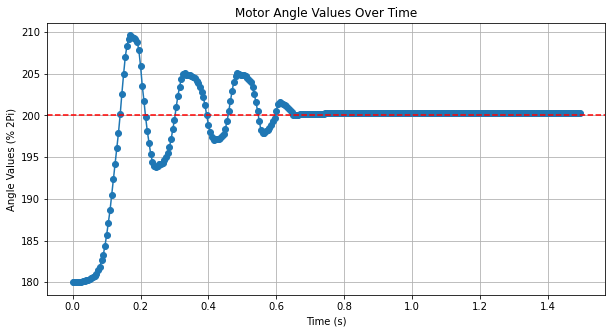

motors stopped!


In [83]:
def goTo(controller, target, time = 1., dt = 0.005, motorid =1):
    anglevalues =[]
    N = (int)(time / dt) # number of iterations

    def oneStep():
        nonlocal anglevalues
        currentAngle = mc.readPosition(motorid)
        anglevalues+=[currentAngle]
        tau = controller.compute(target,currentAngle) # returns the torque necessary to reach the target

        mc.applyTorqueToMotor(motorid,tau)

    run_until(oneStep, N=N, dt=dt)

    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)

    time_values = [i * dt for i in range(len(anglevalues))]
    # Plotting the angle values
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, anglevalues, marker='o', linestyle='-')
    plt.axhline(y=target, color='r', linestyle='--', label='Target Value') # Add horizontal line for target
    plt.title('Motor Angle Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle Values (% 2Pi)')
    plt.grid()
    plt.show()

try:
    pc = PController(0.00016)
    goTo(pc, 200, time = 1.5, motorid=2)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    print("motors stopped!")

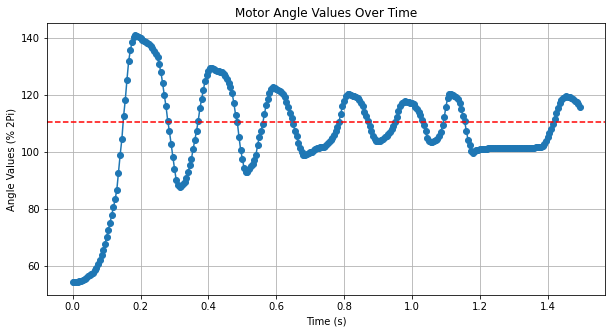

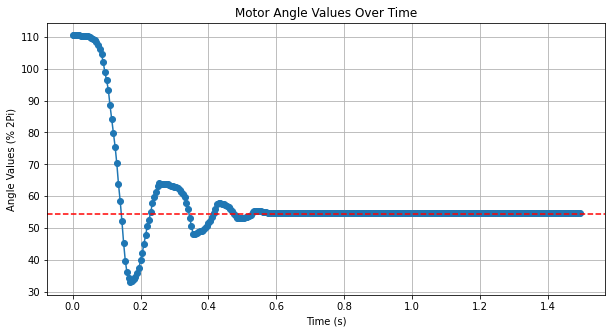

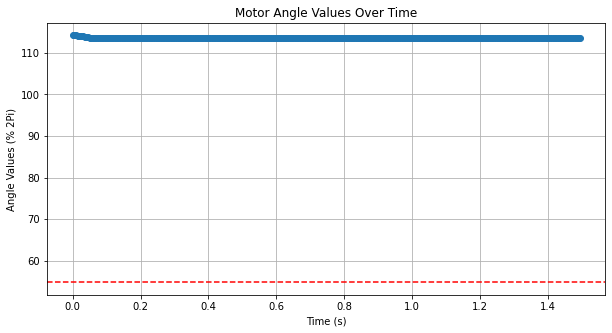

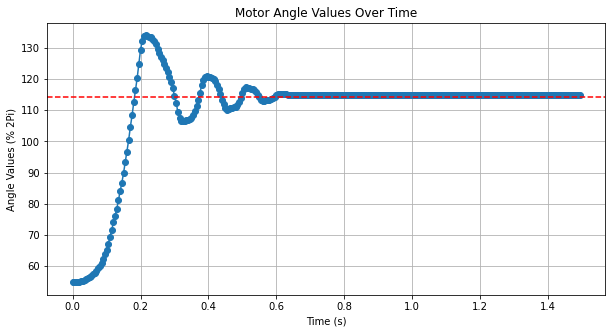

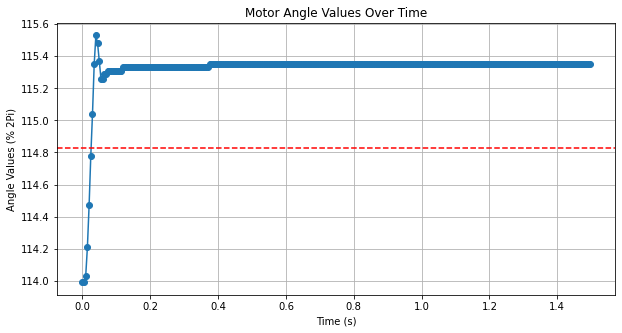

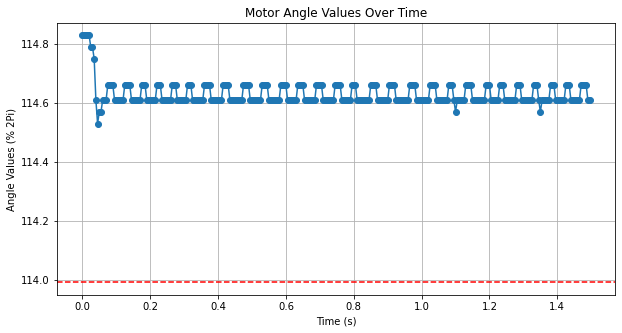

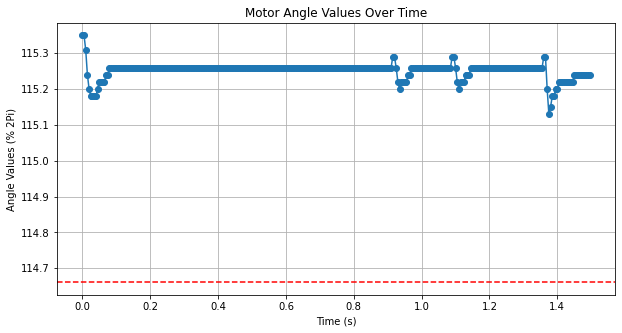

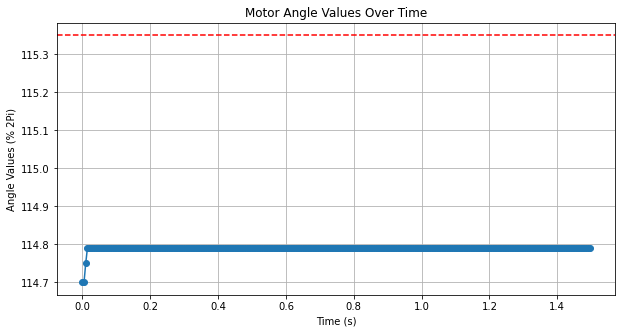

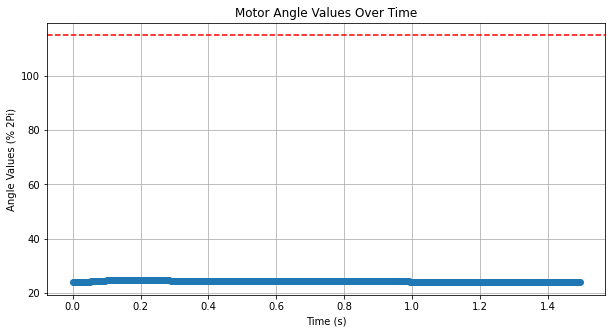

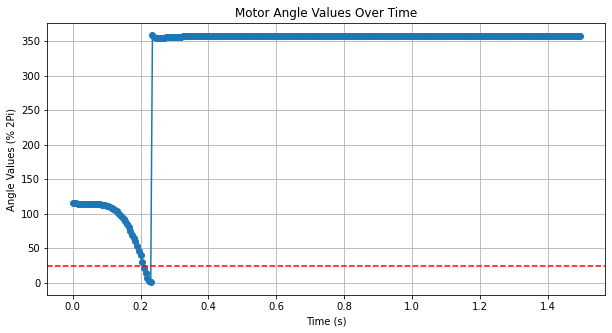

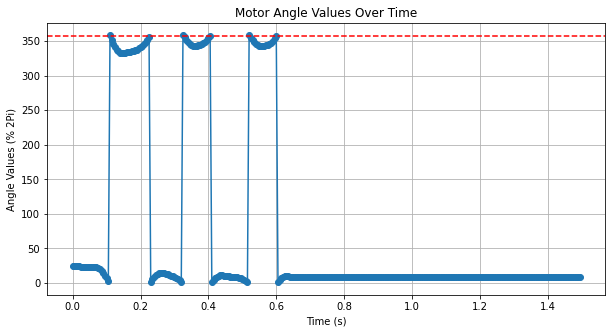

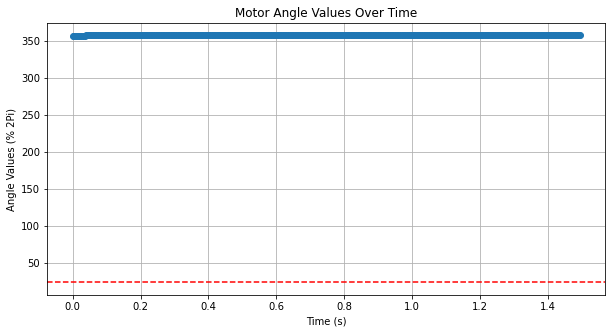

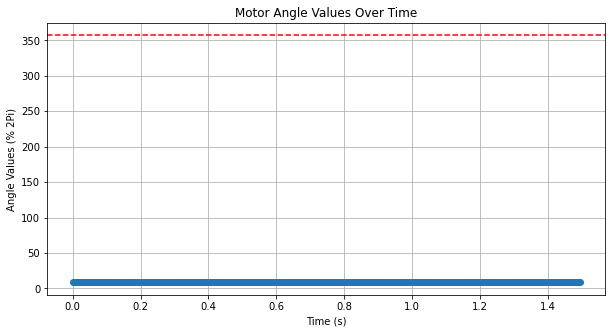

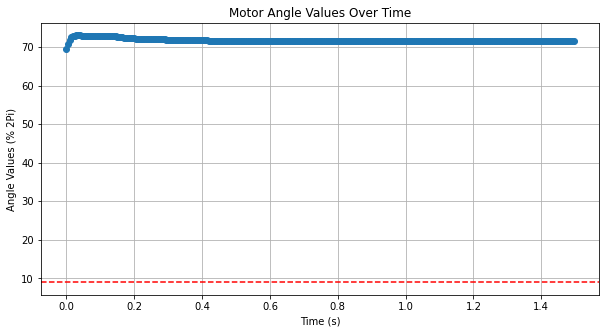

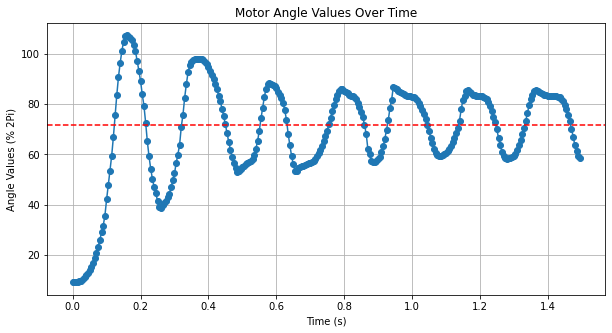

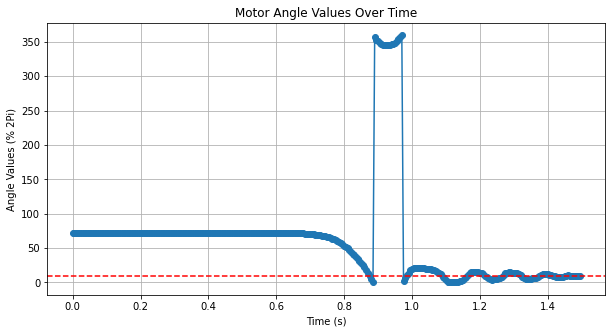

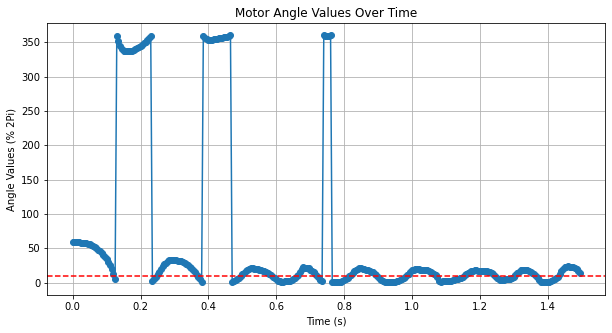

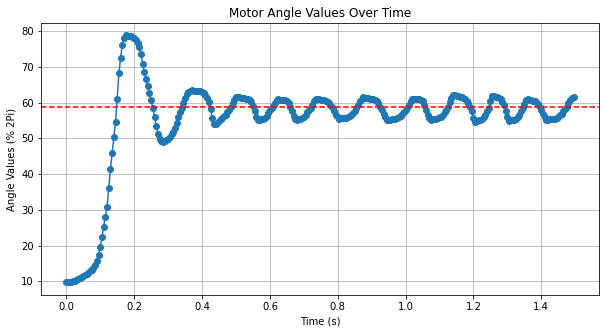

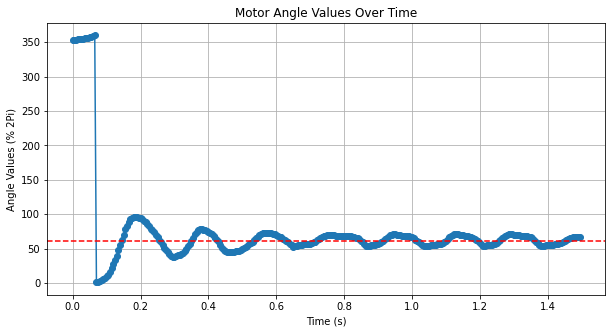

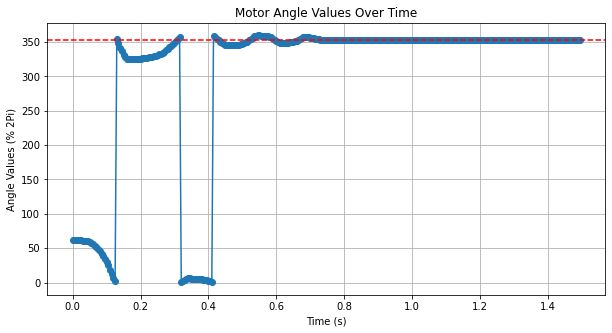

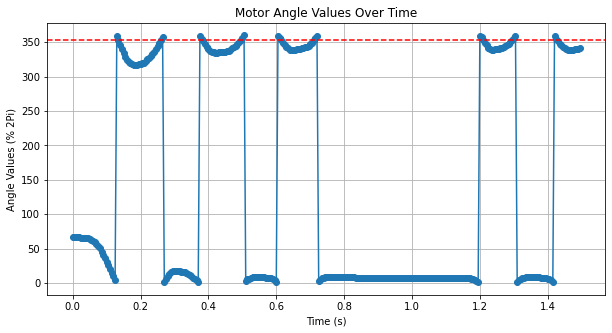

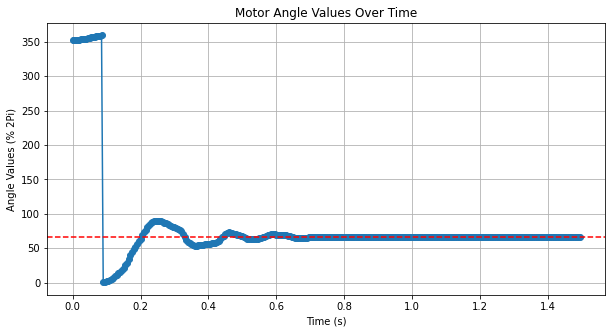

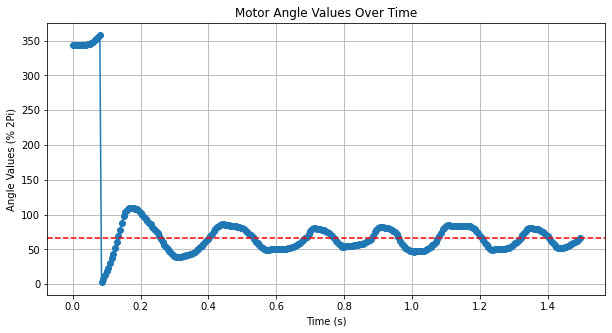

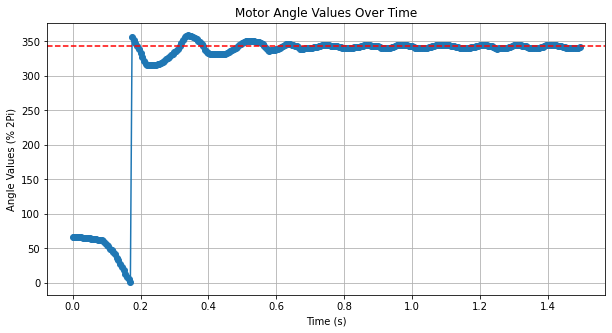

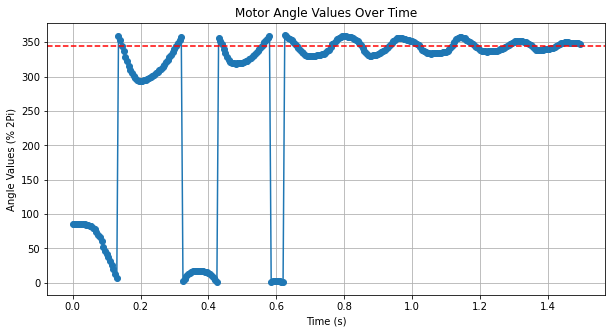

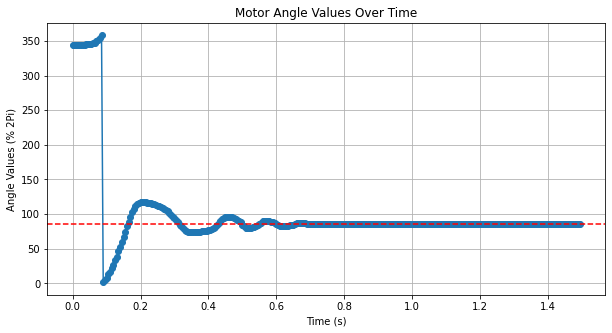

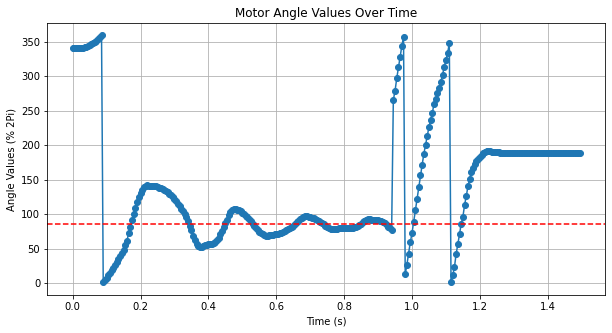

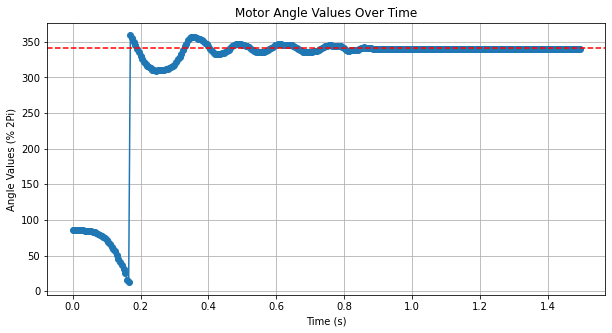

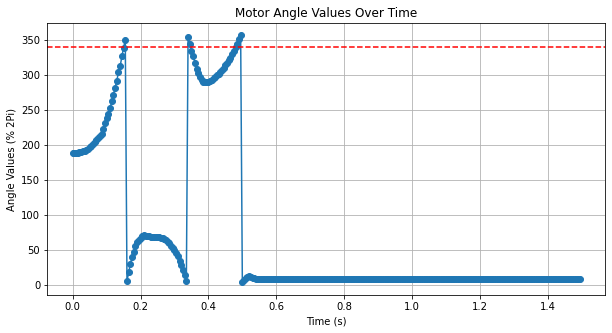

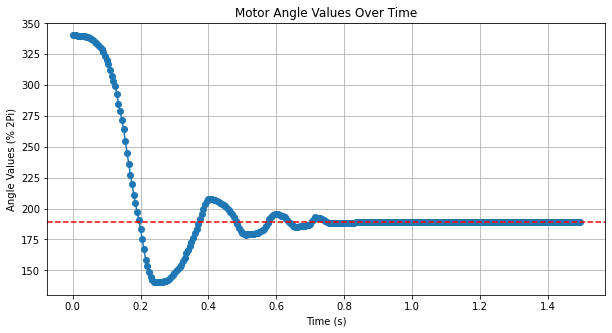

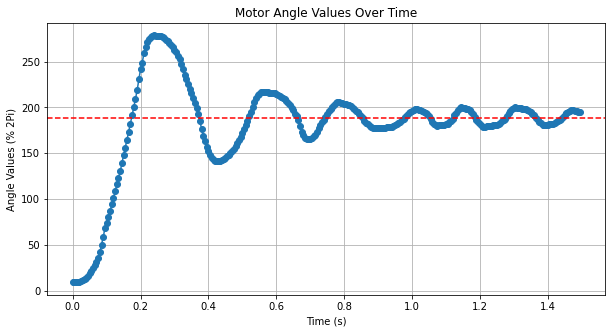

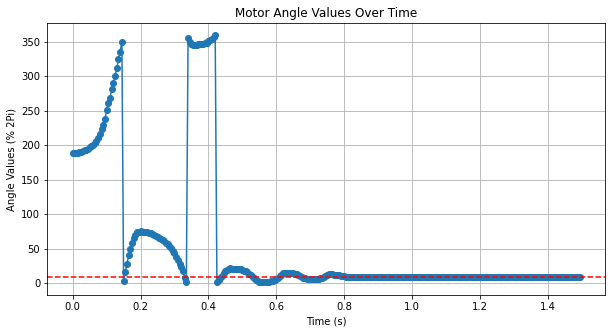

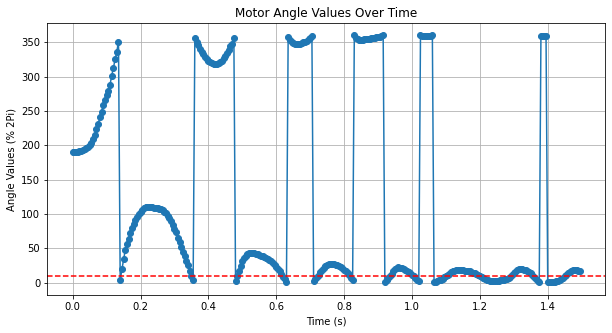

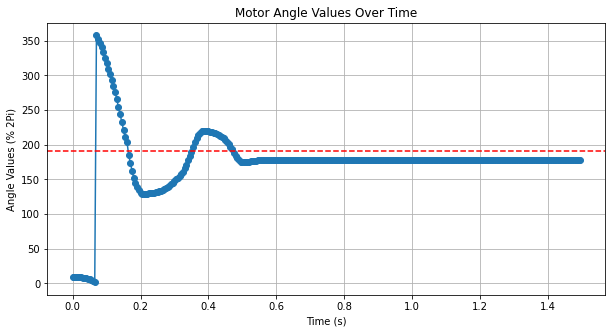

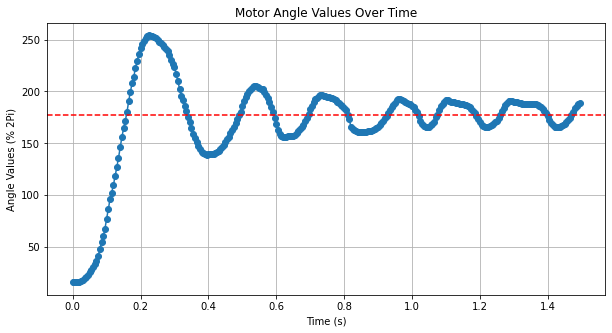

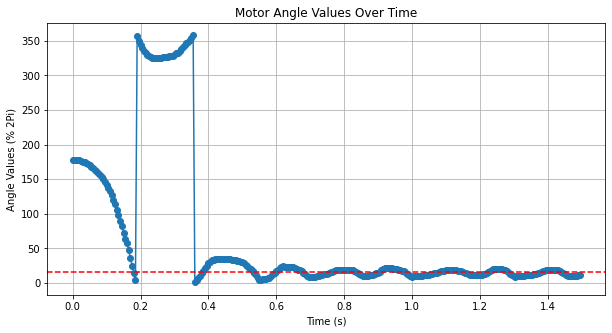

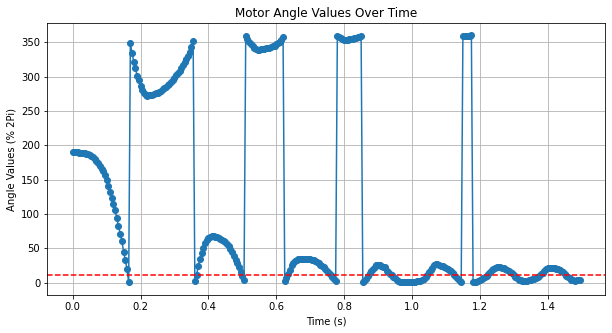

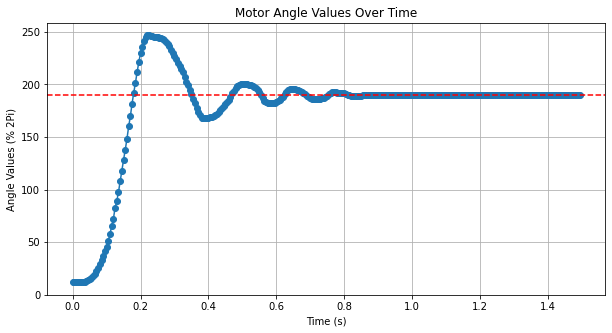

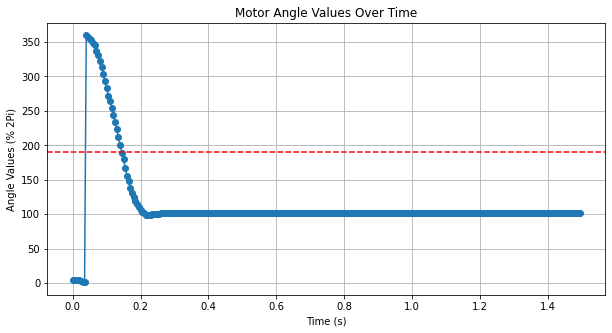

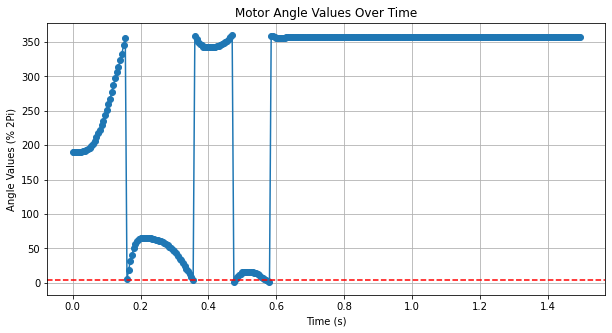

In [91]:
"""Now, write a 30s control loop that does the following: + Motor 1 is configured to track the position
of motor 2 + Motor 2 is configured to track the position of motor 1
Manually mess around with the motors while the loop is running and check that things behave as
you expect. A similar system is implemented in some of the recent cars where the steering wheel and
the wheels are no longer mechanically connected (see https://en.wikipedia.org/wiki/Steer-by-wire )"""

def controlLoop():
    time = 30
    time_to_follow = 1.5
    N = (int)(time / time_to_follow/2) # number of iterations
    anglevalues1 =[]
    anglevalues2 =[]

    for i in range(N):
        currentAngle1 = mc.readPosition(1)
        currentAngle2 = mc.readPosition(2)
        anglevalues1+=[currentAngle1]
        anglevalues2+=[currentAngle2]

        # use go to to make motor 1 track motor 2
        pc1 = PController(0.00016)
        goTo(pc1, currentAngle2, time = 1.5, motorid=1)
        goTo(pc1, currentAngle1, time = 1.5, motorid=2)

        # time.sleep(dt)

    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)

controlLoop()

In [89]:
mc.applyTorqueToMotor(1, 0)
mc.applyTorqueToMotor(2, 0)


mismatch!!! msg.aid: 578 aid: 577
msg:Timestamp: 1728574339.992147    ID:      242    S Rx                DL:  8    92 00 00 00 ff 31 0b 00     Channel: can0


(26, 65523, 58730, 295)